# Everything

## Imports

In [0]:
import os

if not os.path.isdir('Preference_Extraction'):
    print("Setting up colab environment")
    !pip uninstall -y -q pyarrow
    !pip install -q https://s3-us-west-2.amazonaws.com/ray-wheels/latest/ray-0.8.0.dev5-cp36-cp36m-manylinux1_x86_64.whl
    !pip install -q ray[debug]
    !pip install 'ray[tune]' 
    !pip install bayesian-optimization

    !git clone https://github.com/arunraja-hub/Preference_Extraction.git
    # # A hack to force the runtime to restart, needed to include the above dependencies.
    # # Only after first time
    os._exit(0)

In [0]:
## If you are running on Google Colab, please install TensorFlow 2.0 by uncommenting below..

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [0]:
from __future__ import print_function
import argparse
import os
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms.functional as TF
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import datasets, transforms
import torch.autograd as autograd
from torchsummary import summary

from sklearn.utils import shuffle
import tensorflow as tf
import concurrent.futures
import itertools
import os
import random
import sys
import time
import re
import io
import itertools
import sys

import ray
from ray import tune
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.tune.suggest.bayesopt import BayesOptSearch

sys.path.append('Preference_Extraction')
from imports_data import all_load_data

In [0]:
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

## Parameters

In [0]:
params = {
    'num_train': 50,
    'num_tune': 25,
    'num_val': 400,
    'batch_size': 10,
    'val_batch_size': 10,
    'num_epochs': 100,
    'use_qnet_weights': True, # Flag for running models that use the weights of Qnet vs models that use random weights
    'use_mnist': False,  # Flag for running models on MNIST. If False uses RL Preference Extraction data
    'num_run': 5  # Number of runs (with different data sample) over which to average performance
}

## Subnets Methods

In [0]:
"""
    Original code from What's hidden in a randomly weighted neural network? paper
    Implemented at https://github.com/allenai/hidden-networks
    Remove weigths-initialisation since it is not relevant for us
"""

class GetSubnet(autograd.Function):
    @staticmethod
    def forward(ctx, scores, k):
        # Get the supermask by sorting the scores and using the top k%
        out = scores.clone()
        _, idx = scores.flatten().sort()
        j = int((1 - k) * scores.numel())

        # flat_out and out access the same memory.
        flat_out = out.flatten()
        flat_out[idx[:j]] = 0
        flat_out[idx[j:]] = 1

        return out

    @staticmethod
    def backward(ctx, g):
        # send the gradient g straight-through on the backward pass.
        return g, None

class SupermaskConv(nn.Conv2d):
    def __init__(self, *args, k, scores_init='kaiming_uniform', **kwargs):
        super().__init__(*args, **kwargs)
        self.k = k
        self.scores_init = scores_init

        # initialize the scores
        self.scores = nn.Parameter(torch.Tensor(self.weight.size()))
        if self.scores_init == 'kaiming_normal':
          nn.init.kaiming_normal_(self.scores)
        elif self.scores_init == 'kaiming_uniform':
          nn.init.kaiming_uniform_(self.scores, a=math.sqrt(5))
        elif self.scores_init == 'xavier_normal':
          nn.init.xavier_normal_(self.scores)
        elif self.scores_init == 'best_activation':
          nn.init.ones_(self.scores)
        else:
          nn.init.uniform_(self.scores)

        # initialize the weights
        nn.init.uniform_(self.weight)
        
        # NOTE: turn the gradient on the weights off
        self.weight.requires_grad = False

    def forward(self, x):
        subnet = GetSubnet.apply(self.scores.abs(), self.k)
        w = self.weight * subnet
        x = F.conv2d(
            x, w, self.bias, self.stride, self.padding, self.dilation, self.groups
        )
        return x

class SupermaskLinear(nn.Linear):
    def __init__(self, *args, k, scores_init='kaiming_uniform', **kwargs):
        super().__init__(*args, **kwargs)
        self.k = k
        self.scores_init = scores_init

        # initialize the scores and weights
        self.scores = nn.Parameter(torch.Tensor(self.weight.size()))
        if self.scores_init == 'kaiming_normal':
          nn.init.kaiming_normal_(self.scores)
        elif self.scores_init == 'kaiming_uniform':
          nn.init.kaiming_uniform_(self.scores, a=math.sqrt(5))
        elif self.scores_init == 'xavier_normal':
          nn.init.xavier_normal_(self.scores)
        elif self.scores_init == 'best_activation':
          nn.init.ones_(self.scores)
        else:
          nn.init.uniform_(self.scores)

        nn.init.uniform_(self.weight)

        # NOTE: turn the gradient on the weights off
        self.weight.requires_grad = False

    def forward(self, x):
        subnet = GetSubnet.apply(self.scores.abs(), self.k)
        w = self.weight * subnet
        return F.linear(x, w, self.bias)
        return x

# NOTE: not used here but we use NON-AFFINE Normalization!
# So there is no learned parameters for your nomralization layer.
class NonAffineBatchNorm(nn.BatchNorm2d):
    def __init__(self, dim):
        super(NonAffineBatchNorm, self).__init__(dim, affine=False)

## Define architecture

In [0]:
class PrefQNet(nn.Module):
    """
      If q_head_index is None, this uses a linear model on the normalized q outputs.
      Otherwise, it gets the Q head with the specified index.
    """ 
    def __init__(self, fine_tune, k, q_head_index, q_means_stds, use_last_linear, init_from_act_index=None):
        super(PrefQNet, self).__init__()
        
        if not params['use_mnist']:
            channels_in = 5
            flattened_shape = 960
        else:
            channels_in = 1
            flattened_shape = 4608

        if fine_tune:
            conv_layer = nn.Conv2d
            dense_layer = nn.Linear
            additional_args = {}
            init_from_act_index = None
        else:
            conv_layer = SupermaskConv
            dense_layer = SupermaskLinear
            additional_args = {'k': k}
            if init_from_act_index is not None:
                additional_args['scores_init'] = 'best_activation'
        
        self.conv1 = conv_layer(in_channels=channels_in, out_channels=16, kernel_size=3, stride=1, bias=True, **additional_args)
        self.conv2 = conv_layer(in_channels=16, out_channels=32, kernel_size=3, stride=2, bias=True, **additional_args)
        self.fc1 = dense_layer(in_features=flattened_shape, out_features=64, bias=True, **additional_args)
        self.fc2 = dense_layer(in_features=64, out_features=3, bias=True, **additional_args)
        
        if init_from_act_index is not None:
            init_scores = np.zeros((3, 64))
            init_scores[:, init_from_act_index] = 1.0
            self.fc2.scores.data = torch.from_numpy(init_scores).float()

        self.fc3 = dense_layer(in_features=3, out_features=1, bias=True, **additional_args)
        self.linear = nn.Linear(1, 1, bias=True)

        self.qix = q_head_index
        self.qu_mu_s = q_means_stds
        self.use_last_linear = use_last_linear

    def fwd_conv1(self, x):
        x = self.conv1(x)
        return F.relu(x)

    def fwd_conv2(self, x):
        x = self.fwd_conv1(x)
        x = self.conv2(x)
        return F.relu(x)

    def fwd_flat(self, x):
        x = self.fwd_conv2(x)
        return torch.flatten(torch.transpose(x, 1, 3), 1) # Pre-flattening transpose is necessary for TF-Torch conversion

    def fwd_fc1(self, x):
        x = self.fwd_flat(x)
        x = self.fc1(x)
        return F.relu(x)
    
    def fwd_fc2(self, x):
        x = self.fwd_fc1(x)
        return self.fc2(x)

    def forward(self, x):
        x = self.fwd_fc2(x)

        x -= torch.tensor(self.qu_mu_s[0], device=device)
        x /= torch.tensor(self.qu_mu_s[1], device=device)

        if self.qix == None:
          x = self.fc3(x)
        else:
          x = x[: ,self.qix:self.qix+1]

        if self.use_last_linear:
          x = self.linear(x)

        x = torch.sigmoid(x)
        return x.flatten()

## Load Data

In [0]:
# Run this cell for training with original RL Preference Extraction data
if not params['use_mnist']:
    all_raw_data = all_load_data("Preference_Extraction/data/simple_env_1/")

    activations = []
    observations = []
    preferences = []

    for data in all_raw_data:
        for i in range(data.observation.shape[0]):
            observations.append(np.copy(data.observation[i]))
            activations.append(np.copy(data.policy_info["activations"][i]))
            preferences.append((data.policy_info['satisfaction'].as_list()[i] > -6).astype(int))

    activations = np.array(activations)

    xs = np.rollaxis(np.array(observations), 3, 1) # Torch wants channel-first
    ys = np.array(preferences)

In [0]:
# Run this cell for training with MNIST
if params['use_mnist']:
    tr_data_loader = torch.utils.data.DataLoader(
        datasets.MNIST('mnist', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])), batch_size=params['batch_size'], shuffle=True)

    val_data_loader = torch.utils.data.DataLoader(
        datasets.MNIST('mnist', train=False, download=True, 
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])), batch_size=params['val_batch_size'], shuffle=True)

## Loading Weights

In [11]:
new_save_path = "Preference_Extraction/saved_model2"
restored_model = tf.keras.models.load_model(new_save_path)
restored_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
EncodingNetwork/conv2d (Conv (None, 12, 14, 16)        736       
_________________________________________________________________
EncodingNetwork/conv2d_1 (Co (None, 5, 6, 32)          4640      
_________________________________________________________________
flatten (Flatten)            (None, 960)               0         
_________________________________________________________________
EncodingNetwork/dense (Dense (None, 64)                61504     
_________________________________________________________________
dense (Dense)                (None, 3)                 195       
Total params: 67,075
Trainable params: 67,075
Non-trainable params: 0
_________________________________________________________________


In [0]:
original_weights=restored_model.get_weights()

In [0]:
def load_weights(model):
    if not params['use_mnist']:
        model.conv1.weight.data = torch.from_numpy(np.transpose(original_weights[0]))
        model.fc1.weight.data = torch.from_numpy(np.transpose(original_weights[4]))
    else:
        model.conv1.weight.data = torch.from_numpy(np.transpose(original_weights[0][:,:,:1,:]))
        mnist_flt_weights = np.random.rand(64, 4608)
        mnist_flt_weights[:, :original_weights[4].shape[0]] = np.transpose(original_weights[4])
        mnist_flt_weights = mnist_flt_weights.astype(np.float32)
        model.fc1.weight.data = torch.from_numpy(mnist_flt_weights)

    model.conv1.bias.data = torch.from_numpy(original_weights[1])
    model.conv2.weight.data = torch.from_numpy(np.transpose(original_weights[2]))
    model.conv2.bias.data = torch.from_numpy(original_weights[3])
    model.fc1.bias.data = torch.from_numpy(original_weights[5])
    model.fc2.weight.data = torch.from_numpy(np.transpose(original_weights[6]))
    model.fc2.bias.data = torch.from_numpy(original_weights[7])
    model.fc3.weight.data = torch.from_numpy(np.ones(shape=[1,3], dtype=np.float32))
    model.fc3.bias.data = torch.from_numpy(np.zeros(shape=[1], dtype=np.float32))
    model.to(device)

In [0]:
test_model = PrefQNet(k=1, fine_tune=False, q_head_index=None, q_means_stds=[[0, 0, 0], [1, 1, 1]], use_last_linear=True).to(device)

if params['use_qnet_weights']:
    load_weights(test_model)

## Test the weights loaded properly

In [0]:
def get_numpy_tensor(tensor):
  return tensor.detach().cpu().numpy()

In [0]:
# Comparing that the models have identical observations for identical images
tf_conv1_fn = tf.keras.models.Model(inputs=restored_model.input, outputs=restored_model.layers[0].output)
tf_conv2_fn = tf.keras.models.Model(inputs=restored_model.input, outputs=restored_model.layers[1].output)
tf_flt_fn = tf.keras.models.Model(inputs=restored_model.input, outputs=restored_model.layers[2].output)
tf_fc1_fn = tf.keras.models.Model(inputs=restored_model.input, outputs=restored_model.layers[3].output)

def npsigmoid(x):
  return 1/(1 + np.exp(-x)) 

def check_same(torch_layer, tf_layer):
    torch_out = np.transpose(get_numpy_tensor(torch_layer(single_observation_torch)))
    torch_out = torch_out.reshape(torch_out.shape[:-1])
    tf_out = tf_layer(single_observation)[0].numpy()
    np.testing.assert_allclose(torch_out, tf_out, rtol=.1, atol=5)  

# due to shape of original TF model this test can be done only when use_mnist = False
if not params['use_mnist'] and params['use_qnet_weights']:
    for i in range(len(all_raw_data[0].observation)):

        single_observation = np.array([all_raw_data[0].observation[i]])
        single_observation_torch = torch.Tensor(np.array([np.transpose(all_raw_data[0].observation[i])]))

        single_observation_torch = single_observation_torch.to(device)

        check_same(test_model.fwd_conv1, tf_conv1_fn)
        check_same(test_model.fwd_conv2, tf_conv2_fn)
        check_same(test_model.fwd_flat, tf_flt_fn)
        check_same(test_model.fwd_flat, tf_flt_fn)

        fc1_torch_out = np.transpose(get_numpy_tensor(test_model.fwd_fc1(single_observation_torch)))
        fc1_torch_out = fc1_torch_out.reshape(fc1_torch_out.shape[:-1])
        fc1_tf_out = tf_fc1_fn(single_observation)[0].numpy()
        
        np.testing.assert_allclose(fc1_torch_out, fc1_tf_out, rtol=.1, atol=5)
        old_activations = all_raw_data[0].policy_info["activations"][i]
        np.testing.assert_allclose(fc1_torch_out, old_activations, rtol=.1, atol=5)
        np.testing.assert_allclose(old_activations, fc1_tf_out, rtol=.1, atol=5)

        check_same(test_model.fwd_fc2, restored_model)

        torch_out = np.transpose(get_numpy_tensor(test_model.forward(single_observation_torch)))
        torch_out = torch_out.reshape(torch_out.shape[:-1])
        tf_out = npsigmoid(np.sum(restored_model(single_observation)[0].numpy()))
        np.testing.assert_allclose(torch_out, tf_out, rtol=.1, atol=5)  

## Modelling

### Get data to normalize qHeads

In [17]:
def get_q_heads_mu_and_sigma(model, all_obs, num_obs):
    
    model.eval()

    all_obs = shuffle(all_obs)
    obs_to_pass = all_obs[:num_obs]

    obs_tensor = torch.Tensor(obs_to_pass)
    obs_tensor = obs_tensor.to(device)
    qheads_values = model.fwd_fc2(obs_tensor).detach().cpu().numpy()

    mu = qheads_values.mean(axis=0)
    s = qheads_values.std(axis=0)

    print("mu", mu, "s", s)
    
    return np.array([mu, s])

if params['use_mnist']:
    img_batch, label = iter(tr_data_loader).next()
    xs = img_batch

q_mu_s = get_q_heads_mu_and_sigma(test_model, xs, 10000)

mu [ 92.95298  68.86261 138.85707] s [47.83527  51.530537 78.17806 ]


### Methods to inspect performance

In [0]:
def get_number_of_new_scores_in_top_k(new_scores, old_scores, k):
    new_top_k_scores = set(new_scores[:int(len(new_scores) * k)])
    old_top_k_scores = set(old_scores[:int(len(old_scores) * k)])

    return len(old_top_k_scores) - len(new_top_k_scores.intersection(old_top_k_scores))

def model_scores_to_dict(model):
    return {
        'conv1': model.conv1.scores.detach().cpu().numpy().flatten().argsort(),
        'conv2': model.conv2.scores.detach().cpu().numpy().flatten().argsort(),
        'fc1': model.fc1.scores.detach().cpu().numpy().flatten().argsort(),
        'fc2': model.fc2.scores.detach().cpu().numpy().flatten().argsort(),
        'fc3': model.fc3.scores.detach().cpu().numpy().flatten().argsort()
    }

def get_no_of_changed_scores(model, previous_scores, k):

    new_scores_idxs = model_scores_to_dict(model)

    score_changes = {}

    for score in new_scores_idxs:
        changed_scores_num = get_number_of_new_scores_in_top_k(new_scores_idxs[score], previous_scores[score], k)
        score_changes[score] = changed_scores_num

    return score_changes, new_scores_idxs

def plot_metric(results_dict, metric):
    plt.title(metric)
    plt.xlabel('Epochs')
    plt.plot(list(range(1, params['num_epochs'] + 1)), results_dict[f'train{metric}'], label=f'Train {metric}')
    plt.plot(list(range(1, params['num_epochs'] + 1)), results_dict[f'test{metric}'], label=f'Test {metric}')
    plt.legend()
    plt.show()

def plot_metric_multiple_runs(results_items, metric, train=True):
    plt.title(metric)
    plt.xlabel('Epochs')
    for res_key, res_dict in results_items.items():
        if train:
            plt.plot(list(range(1, params['num_epochs'] + 1)), res_dict[f'train{metric}'], label=f'Train {metric} - {res_key}')
        else:
            plt.plot(list(range(1, params['num_epochs'] + 1)), res_dict[f'test{metric}'], label=f'Test {metric} - {res_key}')
    plt.legend()
    plt.show()

def plot_score_changes(score_changes_dict):
    plt.title('Layer-wise score changes')
    plt.xlabel('Optimisation steps (num_train / batch_size * epochs)')
    for layer in score_changes_dict:
        plt.plot(list(range(1, len(score_changes_dict[layer]) + 1)), score_changes_dict[layer], label=f'{layer}')
    plt.legend()
    plt.show()

### Method to get data for one sample run

In [0]:
def get_data_sample(xs=None, ys=None):

    if not params['use_mnist']:
        xs, ys = shuffle(xs, ys)
        
        train_split = params['num_train']
        tune_split = params['num_train']+params['num_tune']
        test_split = params['num_train']+params['num_tune']+params['num_val']

        tr_data_loader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(torch.Tensor(xs[:train_split]), torch.Tensor(ys[:train_split])),
            batch_size=params['batch_size'])

        tune_data_loader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(torch.Tensor(xs[train_split:tune_split]), torch.Tensor(ys[train_split:tune_split])),
            batch_size=params['batch_size'])

        val_data_loader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(torch.Tensor(xs[tune_split:test_split]), torch.Tensor(ys[tune_split:test_split])),
            batch_size=params['val_batch_size'])
    else:
        tr_data_loader = torch.utils.data.DataLoader(
            datasets.MNIST('mnist', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])), batch_size=params['batch_size'], shuffle=True)

        tune_data_loader = torch.utils.data.DataLoader(
            datasets.MNIST('mnist', train=False, download=True, 
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ])), batch_size=params['batch_size'], shuffle=True)

        val_data_loader = torch.utils.data.DataLoader(
            datasets.MNIST('mnist', train=False, download=True, 
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ])), batch_size=params['val_batch_size'], shuffle=True)
        
    return tr_data_loader, tune_data_loader, val_data_loader

### Single run train/test methods

In [0]:
"""
    Train/Test function for Randomly Weighted Hidden Neural Networks Techniques
    Adapted from https://github.com/NesterukSergey/hidden-networks/blob/master/demos/mnist.ipynb
"""

def compute_metrics(predictions, true_labels):
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    accuracy = np.sum(np.equal((predictions > 0.5).astype(int), true_labels)) / len(true_labels)
    fpr, tpr, thresholds = metrics.roc_curve(true_labels, predictions, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    return accuracy, auc

def train(model, k, device, train_loader, optimizer, criterion):
    
    train_loss = 0
    true_labels = []
    predictions = [] # labels

    model.train()
    train_score_changes = {}
    if k is not None:
        scores = model_scores_to_dict(model)
        train_score_changes = {k: [] for k in scores}

    for data, target in itertools.islice(train_loader, params['num_train']):
        
        data, target = data.to(device), target.to(device)
        if params['use_mnist']:
            target = (target > 0).float()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if k is not None:
            score_changes, scores = get_no_of_changed_scores(model, scores, k)
            for layer_changes in score_changes:
                train_score_changes[layer_changes].append(score_changes[layer_changes])

        train_loss += loss
        predictions.extend(output.detach().cpu().numpy())
        true_labels.extend(target.detach().cpu().numpy())
    
    train_loss /= len(train_loader.dataset)
    accuracy, auc = compute_metrics(predictions, true_labels)

    return train_loss.item(), accuracy, auc, train_score_changes


def test(model, device, criterion, test_loader, num_test):
    true_labels = []
    predictions = [] # labels

    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in itertools.islice(test_loader, num_test):
            data, target = data.to(device), target.to(device)
            if params['use_mnist']:
                target = (target > 0).float()
            output = model(data)
            test_loss += criterion(output, target)

            predictions.extend(output.detach().cpu().numpy())
            true_labels.extend(target.detach().cpu().numpy())
    
    test_loss /= len(test_loader.dataset)
    accuracy, auc = compute_metrics(predictions, true_labels)

    return test_loss.item(), accuracy, auc

def run_model(model, k, learning_rate, weight_decay, num_epochs, tune_scores=True):

  tr_data_loader, tune_data_loader, val_data_loader = get_data_sample(xs, ys)

  train_params = model.named_parameters()
  train_params = [p for p in train_params if p[1].requires_grad]
  if not tune_scores:
    train_params = [p for p in train_params if 'linear' in p[0]]

  print('train_params', [p[0] for p in train_params])

  optimizer = optim.Adam(
      [p[1] for p in train_params],
      lr=learning_rate,
      weight_decay=weight_decay
  )

  criterion = nn.BCELoss().to(device)
  scheduler = CosineAnnealingLR(optimizer, T_max=len(tr_data_loader))

  train_losses = []
  test_losses = []
  tune_losses = []
  train_accs = []
  train_aucs = []
  test_accs = []
  test_aucs = []
  score_changes = []
  

  for epoch in range(num_epochs):
      train_loss, train_accuracy, train_auc, train_score_changes = train(model, k, device, tr_data_loader, optimizer, criterion)
      tune_loss, _, _ = test(model, device, criterion, tune_data_loader, params['num_tune'])
      test_loss, test_accuracy, test_auc = test(model, device, criterion, val_data_loader, params['num_val'])
      scheduler.step()

      score_changes.append(train_score_changes)
      train_losses.append(train_loss)
      tune_losses.append(tune_loss)
      test_losses.append(test_loss)
      train_accs.append(train_accuracy)
      train_aucs.append(train_auc)
      test_accs.append(test_accuracy)
      test_aucs.append(test_auc)

  merged_score_changes = {k: [] for k in score_changes[0].keys()}
  for d in score_changes:
    for k in d:
        merged_score_changes[k].extend(d[k])

  return {'trainLoss': train_losses, 'testLoss': test_losses, 'tuneLoss': tune_losses,
          'trainAccuracy': train_accs, 'testAccuracy': test_accs,
          'trainAUC': train_aucs, 'testAUC': test_aucs, 'scoreChanges': merged_score_changes}

In [0]:
def multi_runs(fine_tune, K, q_head_index, q_means_stds, use_last_linear, init_from_act_index, 
               learning_rate, weight_decay, plots=False):

    averaged_results = {}    
    for run_ix in range(params['num_run']):
        
        model = PrefQNet(fine_tune=fine_tune, k=K, q_head_index=q_head_index, q_means_stds=q_means_stds,
                         use_last_linear=use_last_linear, init_from_act_index=init_from_act_index)
        
        if params['use_qnet_weights']:
            load_weights(model)

        results = run_model(model, K, learning_rate=learning_rate, weight_decay=weight_decay, num_epochs=params['num_epochs'])
        
        print(f'Train pass no. {run_ix+1}')
        if (run_ix == 0) and plots:
            print('Debug charts for first training run')
            plot_metric(results, 'Loss')
            plot_metric(results, 'Accuracy')
            plot_metric(results, 'AUC')

        for val in results:
            if len(results[val]) > 0 and val != 'scoreChanges':
                if val not in averaged_results:
                    averaged_results[val] = [results[val][-1]]
                else:
                    averaged_results[val].append(results[val][-1])         
    
    return averaged_results, {x: sum(averaged_results[x]) / params['num_run'] for x in averaged_results}

## Initialise Subnets Search with activation that obtained optimal AUC in previous experiment

We do this both as a sanity check as well as a potential improvement

In [22]:
from sklearn import metrics 

acts = []
prefs = []

for data in all_raw_data:
    for i in range(data.observation.shape[0]):
        acts.append(np.copy(data.policy_info["activations"][i]))
        prefs.append((data.policy_info['satisfaction'].as_list()[i] > -6).astype(int))

acts = np.array(acts)
prefs = np.array(prefs)

def display_auc_info(xs, ys):
    
    def calc_auc(xs, ys, i):
        fpr, tpr, thresholds = metrics.roc_curve(ys, xs[:,i], pos_label=1)
        return metrics.auc(fpr, tpr)


    multi_runs_aucs = []
    for run_ix in range(50):
        xs, ys = shuffle(xs, ys)
        flat_xs = np.reshape(xs, (xs.shape[0], -1))
        aucs = []    
        
        for i in range(flat_xs.shape[1]):
            auc = calc_auc(flat_xs[:params['num_train']], ys[:params['num_train']], i)
            aucs.append(auc)  

        aucs = np.array(aucs)
        multi_runs_aucs.append(aucs)

    aucs = np.array(multi_runs_aucs)
    aucs = aucs.mean(axis=0)

    print("AUC from only picking a single activation")
    print(np.argmin(aucs), "train", 1-np.min(aucs), "val", 1-calc_auc(flat_xs[params['num_train']:], ys[params['num_train']:], np.argmin(aucs)))
    print(np.argmax(aucs), "train", np.max(aucs), "val", calc_auc(flat_xs[params['num_train']:], ys[params['num_train']:], np.argmax(aucs)))
  
display_auc_info(acts, prefs)

AUC from only picking a single activation
34 train 0.8175228060487797 val 0.8204135977651564
13 train 0.6141826397837054 val 0.6180580985329214


In [0]:
# Code to visualize the model.

def model_scores_3d_to_dict(model):
    return {
        'conv1': get_numpy_tensor(model.conv1.scores),
        'conv2': get_numpy_tensor(model.conv2.scores),
        'fc1': get_numpy_tensor(model.fc1.scores),
        'fc2': get_numpy_tensor(model.fc2.scores),
        'fc3': get_numpy_tensor(model.fc3.scores),
    }

def visualize_conv_scores(scores):
  sub_size = .35
  fig, axs = plt.subplots(scores.shape[0], scores.shape[1], figsize=(scores.shape[1]*sub_size, scores.shape[0]*sub_size))

  for i in range(scores.shape[0]):
    for j in range(scores.shape[1]):
      im = axs[i, j].imshow(scores[i, j], vmin=0, vmax=1)
      axs[i, j].get_xaxis().set_visible(False)
      axs[i, j].get_yaxis().set_visible(False)

  fig.colorbar(im, ax=axs.ravel().tolist())
  plt.show()

def visualize_fc_scores(scores):
  point_size = .05
  plt.figure(figsize =(18,1.5))
  plt.imshow(scores, vmin=0, vmax=1)
  plt.colorbar()
  plt.show()

def visulaize_last_linear(model):
  print("weight", get_numpy_tensor(model.linear.weight), "bias", get_numpy_tensor(model.linear.bias))

def visualize_model(model):
  scores_dict = model_scores_3d_to_dict(model)
  visualize_conv_scores(scores_dict['conv1'])
  visualize_conv_scores(scores_dict['conv2'])
  visualize_fc_scores(scores_dict['fc1'])
  visualize_fc_scores(scores_dict['fc2'])
  visualize_fc_scores(scores_dict['fc3'])
  visulaize_last_linear(model)

Initialized model
weight [[0.3145653]] bias [-0.53240883]
train_params ['linear.weight', 'linear.bias']
results trainAUC 0.19833333333333333 results testAUC 0.17784655061250806 trainAccuracy 0.4 testAccuracy 0.42
train_params ['linear.weight', 'linear.bias']
After training inear layer
results trainAUC 0.7905844155844156 results testAUC 0.8160677083333333 trainAccuracy 0.74 testAccuracy 0.7175


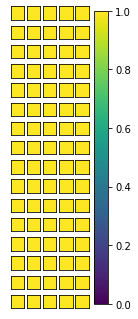

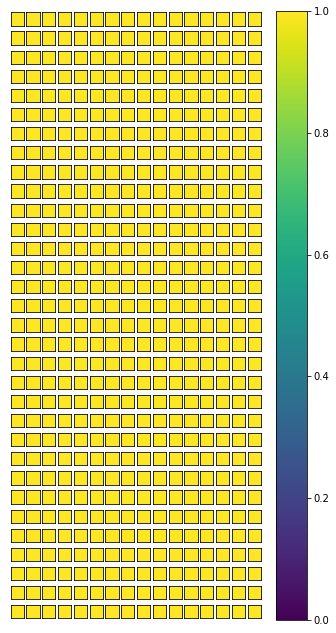

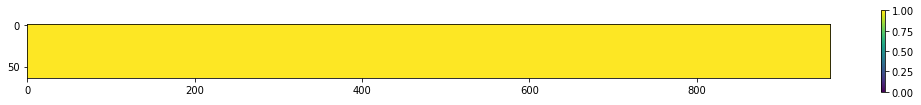

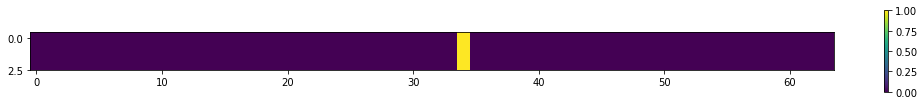

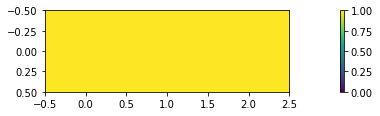

weight [[-0.3725175]] bias [-0.48629588]
train_params ['conv1.bias', 'conv1.scores', 'conv2.bias', 'conv2.scores', 'fc1.bias', 'fc1.scores', 'fc2.bias', 'fc2.scores', 'fc3.bias', 'fc3.scores', 'linear.weight', 'linear.bias']
After training full model
results trainAUC 1.0 results testAUC 0.8363851469441531 trainAccuracy 1.0 testAccuracy 0.815


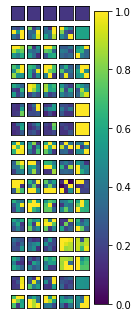

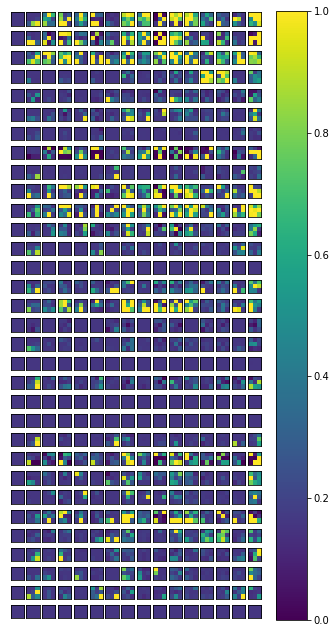

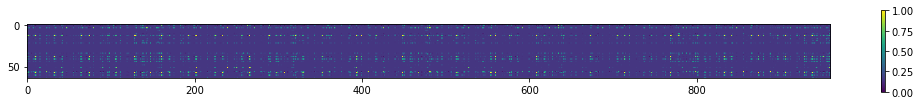

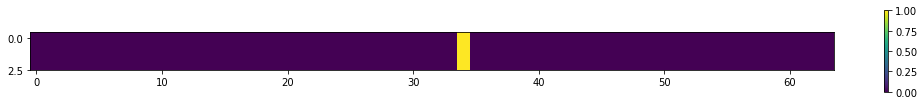

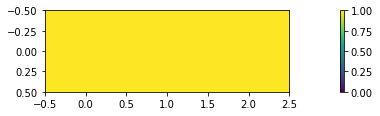

weight [[-1.0134389]] bias [-0.39573568]


In [24]:
best_act_index = 34
K = 66774 / 67152  # Num of weigths with all dense activations except one set to 0 / Number of total weights

def print_results_summary(results):
  print("results trainAUC", results['trainAUC'][-1], "results testAUC", results['testAUC'][-1],
      "trainAccuracy", results['trainAccuracy'][-1], "testAccuracy", results['testAccuracy'][-1])

model = PrefQNet(fine_tune=False, k=K, q_head_index=None, q_means_stds=q_mu_s, 
                     use_last_linear=True, init_from_act_index=best_act_index)

if params['use_qnet_weights']:
    load_weights(model)

print("Initialized model")
visulaize_last_linear(model)
results = run_model(model, K, learning_rate=0, weight_decay=0, num_epochs=1, tune_scores=False)
print_results_summary(results)

results = run_model(model, K, learning_rate=0.005, weight_decay=0.0005, num_epochs=100, tune_scores=False)
print("After training inear layer")
print_results_summary(results)
visualize_model(model)

results = run_model(model, .5, learning_rate=0.005, weight_decay=0.0005, num_epochs=100, tune_scores=True)
print("After training full model")
print_results_summary(results)
visualize_model(model)

## Getting Results for Different Combinations

In [0]:
params['num_epochs'] = 100

In [26]:
multi_runs(fine_tune=True, K=None, q_head_index=None, q_means_stds=q_mu_s, 
           use_last_linear=True, init_from_act_index=None,
           learning_rate=0.01, weight_decay=0.001, plots=False)

train_params ['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'linear.weight', 'linear.bias']
Train pass no. 1
train_params ['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'linear.weight', 'linear.bias']
Train pass no. 2
train_params ['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'linear.weight', 'linear.bias']
Train pass no. 3
train_params ['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'linear.weight', 'linear.bias']
Train pass no. 4
train_params ['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'linear.weight', 'linear.bias']
Train pass n

({'testAUC': [0.7425660863958736,
   0.7495944041064923,
   0.8149418867523073,
   0.832152380952381,
   0.7593920765027322],
  'testAccuracy': [0.6825, 0.68, 0.79, 0.725, 0.715],
  'testLoss': [0.14369991421699524,
   0.10840973258018494,
   0.11393044888973236,
   0.08791960775852203,
   0.11996907740831375],
  'trainAUC': [1.0, 1.0, 1.0, 1.0, 1.0],
  'trainAccuracy': [1.0, 1.0, 1.0, 1.0, 1.0],
  'trainLoss': [0.00022888950479682535,
   0.00034606122062541544,
   0.00019075571617577225,
   0.0001871024287538603,
   0.000334643671521917],
  'tuneLoss': [0.31167811155319214,
   0.0728064700961113,
   0.12436790019273758,
   0.08697091788053513,
   0.15600112080574036]},
 {'testAUC': 0.7797293669419573,
  'testAccuracy': 0.7184999999999999,
  'testLoss': 0.11478575617074967,
  'trainAUC': 1.0,
  'trainAccuracy': 1.0,
  'trainLoss': 0.00025749050837475806,
  'tuneLoss': 0.1503649041056633})

In [27]:
multi_runs(fine_tune=True, K=None, q_head_index=None, q_means_stds=[[0,0,0],[1,1,1]], 
           use_last_linear=True, init_from_act_index=None,
           learning_rate=0.01, weight_decay=0.001, plots=False)

train_params ['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'linear.weight', 'linear.bias']
Train pass no. 1
train_params ['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'linear.weight', 'linear.bias']
Train pass no. 2
train_params ['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'linear.weight', 'linear.bias']
Train pass no. 3
train_params ['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'linear.weight', 'linear.bias']
Train pass no. 4
train_params ['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'linear.weight', 'linear.bias']
Train pass n

({'testAUC': [0.7328301691046789,
   0.5967592711572564,
   0.8431420420960655,
   0.725570137972095,
   0.6788890051260592],
  'testAccuracy': [0.7275, 0.5825, 0.795, 0.69, 0.6275],
  'testLoss': [0.20302526652812958,
   0.2498791664838791,
   0.31041622161865234,
   0.21097546815872192,
   0.1947256475687027],
  'trainAUC': [1.0, 1.0, 0.9429590017825312, 1.0, 1.0],
  'trainAccuracy': [1.0, 1.0, 0.98, 1.0, 1.0],
  'trainLoss': [5.690735633834265e-05,
   0.0005604116013273597,
   0.1286820024251938,
   4.147467188886367e-05,
   5.80628402531147e-05],
  'tuneLoss': [0.1545107215642929,
   0.33216774463653564,
   0.3864519000053406,
   0.5384669303894043,
   0.09225846081972122]},
 {'testAUC': 0.7154381250912311,
  'testAccuracy': 0.6845,
  'testLoss': 0.23380435407161712,
  'trainAUC': 0.9885918003565063,
  'trainAccuracy': 0.9960000000000001,
  'trainLoss': 0.025879771779000294,
  'tuneLoss': 0.30077115148305894})

In [28]:
multi_runs(fine_tune=True, K=None, q_head_index=None, q_means_stds=q_mu_s, 
           use_last_linear=False, init_from_act_index=None,
           learning_rate=0.01, weight_decay=0.001, plots=False)

train_params ['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'linear.weight', 'linear.bias']
Train pass no. 1
train_params ['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'linear.weight', 'linear.bias']
Train pass no. 2
train_params ['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'linear.weight', 'linear.bias']
Train pass no. 3
train_params ['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'linear.weight', 'linear.bias']
Train pass no. 4
train_params ['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'linear.weight', 'linear.bias']
Train pass n

({'testAUC': [0.7799243557998423,
   0.8474290756437338,
   0.6959963113809267,
   0.8145163435197744,
   0.80488],
  'testAccuracy': [0.7275, 0.79, 0.6575, 0.735, 0.715],
  'testLoss': [0.15210247039794922,
   0.06543733179569244,
   0.1438302993774414,
   0.11642592400312424,
   0.08499810844659805],
  'trainAUC': [1.0, 1.0, 1.0, 1.0, 1.0],
  'trainAccuracy': [1.0, 1.0, 1.0, 1.0, 1.0],
  'trainLoss': [0.0005559877608902752,
   0.00024022237630560994,
   0.00035819842014461756,
   0.0008463073172606528,
   0.0003551077388692647],
  'tuneLoss': [0.11408452689647675,
   0.06933920085430145,
   0.16666249930858612,
   0.11227207630872726,
   0.23451507091522217]},
 {'testAUC': 0.7885492172688554,
  'testAccuracy': 0.7249999999999999,
  'testLoss': 0.11255882680416107,
  'trainAUC': 1.0,
  'trainAccuracy': 1.0,
  'trainLoss': 0.00047116472269408404,
  'tuneLoss': 0.13937467485666274})

In [0]:
multi_runs(fine_tune=True, K=None, q_head_index=None, q_means_stds=q_mu_s, 
           use_last_linear=True, init_from_act_index=None,
           learning_rate=0.005, weight_decay=0.005, plots=False)

train_params ['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'linear.weight', 'linear.bias']


In [0]:
multi_runs(fine_tune=True, K=None, q_head_index=0, q_means_stds=q_mu_s, 
           use_last_linear=True, init_from_act_index=None,
           learning_rate=0.01, weight_decay=0.005, plots=False)

In [0]:
multi_runs(fine_tune=True, K=None, q_head_index=None, q_means_stds=q_mu_s, 
           use_last_linear=True, init_from_act_index=None,
           learning_rate=0.02, weight_decay=0.02, plots=False)

In [0]:
multi_runs(fine_tune=False, K=0.9, q_head_index=None, q_means_stds=q_mu_s, 
           use_last_linear=True, init_from_act_index=None,
           learning_rate=0.01, weight_decay=0.001, plots=False)

In [0]:
multi_runs(fine_tune=False, K=0.6, q_head_index=None, q_means_stds=q_mu_s, 
           use_last_linear=True, init_from_act_index=None,
           learning_rate=0.01, weight_decay=0.001, plots=False)

In [0]:
multi_runs(fine_tune=False, K=0.6, q_head_index=None, q_means_stds=q_mu_s, 
           use_last_linear=True, init_from_act_index=None,
           learning_rate=0.001, weight_decay=0.001, plots=False)

In [0]:
multi_runs(fine_tune=False, K=0.9, q_head_index=None, q_means_stds=q_mu_s, 
           use_last_linear=False, init_from_act_index=None,
           learning_rate=0.005, weight_decay=0.001, plots=False)

In [0]:
multi_runs(fine_tune=False, K=0.95, q_head_index=None, q_means_stds=q_mu_s, 
           use_last_linear=True, init_from_act_index=34,
           learning_rate=0.01, weight_decay=0.0001, plots=False)

In [0]:
multi_runs(fine_tune=False, K=0.95, q_head_index=0, q_means_stds=q_mu_s, 
           use_last_linear=True, init_from_act_index=34,
           learning_rate=0.01, weight_decay=0.0005, plots=False)

In [0]:
multi_runs(fine_tune=False, K=0.95, q_head_index=0, q_means_stds=[[0,0,0], [1,1,1]], 
           use_last_linear=True, init_from_act_index=34,
           learning_rate=0.01, weight_decay=0.0005, plots=False)

In [0]:
multi_runs(fine_tune=False, K=0.5, q_head_index=0, q_means_stds=q_mu_s, 
           use_last_linear=True, init_from_act_index=34,
           learning_rate=0.01, weight_decay=0.0005, plots=False)

In [0]:
multi_runs(fine_tune=False, K=0.5, q_head_index=0, q_means_stds=q_mu_s, 
           use_last_linear=True, init_from_act_index=None,
           learning_rate=0.01, weight_decay=0.0005, plots=False)

In [0]:
multi_runs(fine_tune=False, K=0.95, q_head_index=0, q_means_stds=q_mu_s, 
           use_last_linear=True, init_from_act_index=None,
           learning_rate=0.01, weight_decay=0.0005, plots=False)

In [0]:
multi_runs(fine_tune=False, K=0.95, q_head_index=0, q_means_stds=q_mu_s, 
           use_last_linear=True, init_from_act_index=34,
           learning_rate=0.1, weight_decay=0.0005, plots=False)

In [0]:
multi_runs(fine_tune=False, K=0.95, q_head_index=0, q_means_stds=q_mu_s, 
           use_last_linear=True, init_from_act_index=4,
           learning_rate=0.1, weight_decay=0.0005, plots=False)

In [0]:
multi_runs(fine_tune=False, K=0.99, q_head_index=0, q_means_stds=q_mu_s, 
           use_last_linear=True, init_from_act_index=34,
           learning_rate=0.1, weight_decay=0.0005, plots=False)

In [0]:
multi_runs(fine_tune=True, K=None, q_head_index=None, q_means_stds=q_mu_s, 
           use_last_linear=True, init_from_act_index=None,
           learning_rate=0.1, weight_decay=0.0005, plots=False)

In [0]:
multi_runs(fine_tune=True, K=None, q_head_index=None, q_means_stds=q_mu_s, 
           use_last_linear=True, init_from_act_index=None,
           learning_rate=0.1, weight_decay=0.0005, plots=False)

In [0]:
multi_runs(fine_tune=True, K=None, q_head_index=None, q_means_stds=q_mu_s, 
           use_last_linear=True, init_from_act_index=None,
           learning_rate=0.01, weight_decay=0.0001, plots=False)

In [0]:
# Temporarily added dropout in the code (will not be able to reproduce)
multi_runs(fine_tune=True, K=None, q_head_index=None, q_means_stds=q_mu_s, 
           use_last_linear=True, init_from_act_index=None,
           learning_rate=0.005, weight_decay=0.0005, plots=False)

In [0]:
# Temporarily added dropout in the code (will not be able to reproduce)
multi_runs(fine_tune=True, K=None, q_head_index=None, q_means_stds=q_mu_s, 
           use_last_linear=True, init_from_act_index=34,
           learning_rate=0.005, weight_decay=0.0005, plots=False)

### Results

All runs use the following parameters

```
{'batch_size': 10,
 'num_epochs': 100,
 'num_run': 5,
 'num_train': 50,
 'num_tune': 25,
 'num_val': 400,
 'use_mnist': False,
 'use_qnet_weights': True,
 'val_batch_size': 10}
 ```

| fine_tune      | q_head_index | norm_q_means | use_last_linear | init_from_act_index | K     | Optimiser | learning_rate | momentum | weight_decay | testAUC |
|----------------|--------------|--------------|-----------------|---------------------|-------|-----------|---------------|----------|--------------|---------|
| False          | None (fc3)   | True         | True            | Activation 34       | ~0.99 | Adam      | 0.000         | None     | 0.000        | 0.83    |
| True           | None (fc3)   | True         | True            | None                | 1     | Adam      | 0.01          | None     | 0.001        | 0.83    |
| True           | None (fc3)   | False        | True            | None                | 1     | Adam      | 0.01          | None     | 0.001        | 0.76    |
| True           | None (fc3)   | True         | False           | None                | 1     | Adam      | 0.01          | None     | 0.001        | 0.68    |
| True           | None (fc3)   | True         | False           | None                | 1     | Adam      | 0.005         | None     | 0.005        | 0.81    |
| True           | 0            | True         | True            | None                | 1     | Adam      | 0.01          | None     | 0.005        | 0.76    |
| True           | None (fc3)   | True         | True            | None                | 1     | Adam      | 0.1           | None     | 0.001        | 0.51    |
| True           | None (fc3)   | True         | True            | None                | 1     | Adam      | 0.02          | None     | 0.02         | 0.71    |
| False          | None (fc3)   | True         | True            | None                | 0.9   | Adam      | 0.01          | None     | 0.001        | 0.75    |
| False          | None (fc3)   | True         | True            | None                | 0.6   | Adam      | 0.01          | None     | 0.001        | 0.67    |
| False          | None (fc3)   | True         | True            | None                | 0.6   | Adam      | 0.001         | None     | 0.001        | 0.68    |
| False          | None (fc3)   | True         | False           | None                | 0.9   | Adam      | 0.005         | None     | 0.001        | 0.4     |
| False          | None (fc3)   | True         | True            | Activation 34       | 0.95  | Adam      | 0.01          | None     | 0.0001       | 0.77    |
| False          | 0            | True         | True            | Activation 34       | 0.95  | Adam      | 0.01          | None     | 0.0005       | 0.81    |
| False          | 0            | False        | True            | Activation 34       | 0.95  | Adam      | 0.01          | None     | 0.0005       | 0.71    |
| False          | 0            | True         | True            | Activation 34       | 0.5   | Adam      | 0.01          | None     | 0.0005       | 0.55    |
| False          | 0            | True         | True            | None                | 0.5   | SDG       | 0.1           | 0.9      | 0.0005       | 0.73    |
| False          | 0            | True         | True            | None                | 0.95  | SDG       | 0.1           | 0.9      | 0.0005       | 0.79    |
| False          | 0            | True         | True            | Activation 34       | 0.95  | SDG       | 0.1           | 0.9      | 0.0005       | 0.66    |
| False          | 0            | True         | True            | Activation 4        | 0.95  | SDG       | 0.1           | 0.9      | 0.0005       | 0.57    |
| False          | 0            | True         | True            | Activation 34       | 0.99  | SDG       | 0.1           | 0.9      | 0.0005       | 0.66    |
| True           | None (fc3)   | True         | True            | None                | 1     | SDG       | 0.1           | 0.9      | 0.0005       | 0.5     |
| True           | None (fc3)   | True         | True            | None                | 1     | Adam      | 0.1           | None     | 0.0005       | 0.51    |
| True w/DropOut | None (fc3)   | True         | True            | None                | 1     | Adam      | 0.005         | None     | 0.0005       | 0.81    |
| True w/DropOut | None (fc3)   | True         | True            | Activation 34       | 1     | Adam      | 0.005         | None     | 0.005        | 0.78    |

## Hyperparameters Tuning (not used)

In [0]:
def multi_runs_tune(config, reporter):

    averaged_results = {}
    tuning_losses = []
    for run_ix in range(params['num_run']):
        if params['fine_tune']:
            K = None
        else:
            K = config['k']

        model = PrefQNet(fine_tune=params['fine_tune'], k=K, 
                         q_head_index=None, q_means_stds=q_mu_s, use_last_linear=True, init_from_act_index=34).to(device)

        if params['use_qnet_weights']:
            load_weights(model)
        
        results = run_model(model, K, config['lr'], config['decay'], num_epochs=params['num_epochs'])

        if reporter is not None:  # Hyperp-tuning pass
            tuning_losses.append(results['tuneLoss'][-1])
            reporter(timesteps_total=run_ix, mean_loss=sum(tuning_losses)/len(tuning_losses))

def launch_tune():

    space = {
        "k": (0.05, 0.95), 
        "lr": (0.001, 0.1), 
        'decay': (0.0001, 0.05)
    }

    if params['fine_tune']:
        space['k'] = (1, 1)

    config = {"num_samples": params['num_tune_iters'], "stop": {"timesteps_total": params['num_run']}}

    algo = BayesOptSearch(space, metric="mean_loss", mode="min", utility_kwargs={
        "kind": "ucb", "kappa": 2.5, "xi": 0.0})

    scheduler = AsyncHyperBandScheduler(metric="mean_loss", mode="min")

    return tune.run(multi_runs_tune, resources_per_trial={'gpu': 1, 'cpu': 2}, verbose=1, 
                    name="tune_exp", search_alg=algo, scheduler=scheduler, **config)